A. Hubungkan Google Colab dengan Google Drive

In [48]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


B. Menyiapkan Direktori

In [45]:
base_dir = '/content/drive/MyDrive/PASEM2_MP1'
!ls "/content/drive/MyDrive/PASEM2_MP1"

testing  training  validation


In [40]:
# 1. Menentukan Direktori

testing_dir = os.path.join(base_dir, 'testing')
training_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

In [46]:
# 2. Menentukan Direktori isi testing...(bahan)

airplane_dir = os.path.join(testing_dir, 'airplane/')
car_dir = os.path.join(testing_dir, 'car/')
ship_dir = os.path.join(testing_dir, 'ship/')

print("Jumlah Data Train Tiap Class ")
print('Jumlah Gambar Airplane :', len(os.listdir(airplane_dir)))
print('Jumlah Gambar Car :', len(os.listdir(car_dir)))
print('Jumlah Gambar Ship :', len(os.listdir(ship_dir)))

Jumlah Data Train Tiap Class 
Jumlah Gambar Airplane : 60
Jumlah Gambar Car : 60
Jumlah Gambar Ship : 60


In [42]:
# 3. Direktori Isi Training

training_airplane = os.path.join(training_dir, 'airplane/')
training_car = os.path.join(training_dir, 'car/')
training_ship = os.path.join(training_dir, 'ship/')

# 4. Direktori Isi Validation
validation_airplane = os.path.join(validation_dir, 'airplane/')
validation_car = os.path.join(validation_dir, 'car/')
validation_ship = os.path.join(validation_dir, 'ship/')

C. Menyiapkan Dataset

In [12]:
import os
import random
from shutil import copyfile

def training_validation_split(source, training, validation, training_ratio):
  total_size = len(os.listdir(source))
  training_size = int(training_ratio * total_size)
  validation_size = total_size - training_size

  randomized = random.sample(os.listdir(source), total_size)
  training_files = randomized[0:training_size]
  validation_files = randomized[training_size:total_size]

  os.makedirs(training, exist_ok=True)
  os.makedirs(validation, exist_ok=True)

  # copy file ke folder tujuan
  for i in training_files:
    i_file = source + i
    destination = training + i
    copyfile(i_file, destination)

  for i in validation_files:
    i_file = source + i
    destination = validation + i
    copyfile(i_file, destination)

# rasio data training
training_ratio = 0.8

# pembagian training dan validation
source_00 = airplane_dir
training_00 = training_airplane
validation_00 = validation_airplane
training_validation_split(source_00, training_00, validation_00, training_ratio)

source_01 = car_dir
training_01 = training_car
validation_01 = validation_car
training_validation_split(source_01, training_01, validation_01, training_ratio)

source_02 = ship_dir
training_02 = training_ship
validation_02 = validation_ship
training_validation_split(source_02, training_02, validation_02, training_ratio)


In [ ]:
print('Jumlah Semua Airplane :', len(os.listdir(airplane_dir)))
print('Jumlah Training Airplane :', len(os.listdir(training_airplane)))
print('Jumlah Validation Airplane :', len(os.listdir(validation_airplane)))

print('Jumlah Semua Car :', len(os.listdir(car_dir)))
print('Jumlah Training Car :', len(os.listdir(training_car)))
print('Jumlah Validation Car :', len(os.listdir(validation_car)))

print('Jumlah Semua Ship :', len(os.listdir(ship_dir)))
print('Jumlah Training Ship :', len(os.listdir(training_ship)))
print('Jumlah Validation Ship :', len(os.listdir(validation_ship)))


Jumlah Semua Airplane : 60
Jumlah Training Airplane : 48
Jumlah Validation Airplane : 12
Jumlah Semua Car : 60
Jumlah Training Car : 48
Jumlah Validation Car : 12
Jumlah Semua Ship : 60
Jumlah Training Ship : 48
Jumlah Validation Ship : 12


D. Pre Processing

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
training_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.3,
                    fill_mode = 'nearest',
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    zoom_range = 0.1)

validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.3,
                    fill_mode = 'nearest',
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    zoom_range = 0.1)

In [16]:
training_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical'
)

Found 144 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

E. Model CNN

In [18]:
model = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
     tf.keras.layers.MaxPooling2D(2, 2),
     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(200, activation='relu'),
     tf.keras.layers.Dropout(0.3, seed=112),
     tf.keras.layers.Dense(500, activation='relu'),
     tf.keras.layers.Dropout(0.5, seed=112),
     tf.keras.layers.Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │     3,699,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       100,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,474,963 (43.77 MB)

 Trainable params: 3,824,987 (14.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,649,976 (29.18 MB)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [21]:
history = model.fit(
          training_generator,
          steps_per_epoch=5,
          epochs=30,
          validation_data=validation_generator,
          validation_steps=2,
          verbose=1,
          callbacks=[callbacks]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 651ms/step - accuracy: 0.3114 - loss: 1.2806 - val_accuracy: 0.4000 - val_loss: 1.1149
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.1706 - loss: 1.1083 - val_accuracy: 0.4500 - val_loss: 1.0756
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 602ms/step - accuracy: 0.3703 - loss: 1.0842 - val_accuracy: 0.4000 - val_loss: 1.0556
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3403 - loss: 1.0810 - val_accuracy: 0.4500 - val_loss: 1.0406
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 572ms/step - accuracy: 0.4036 - loss: 1.0708 - val_accuracy: 0.4500 - val_loss: 1.0174
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 504ms/step - accuracy: 0.2824 - loss: 1.0717 - val_accuracy: 0.6500 - val_loss: 1.0207
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 885ms/step - accuracy: 0.5591 - loss: 1.0106 - val_accuracy: 0.4500 - val_loss: 0.9626
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 917ms/step - accuracy: 0.4406 - loss: 1.0046 - val_accuracy: 0.4500 - val_loss: 1

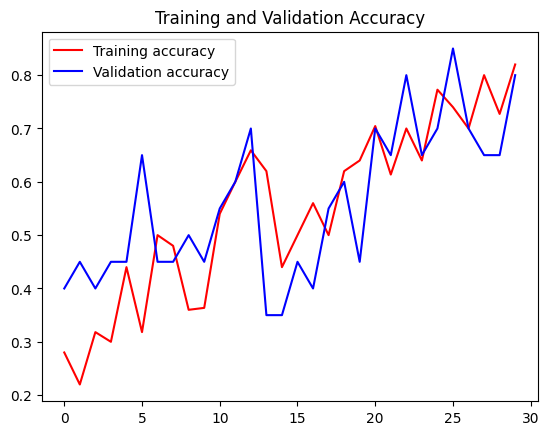

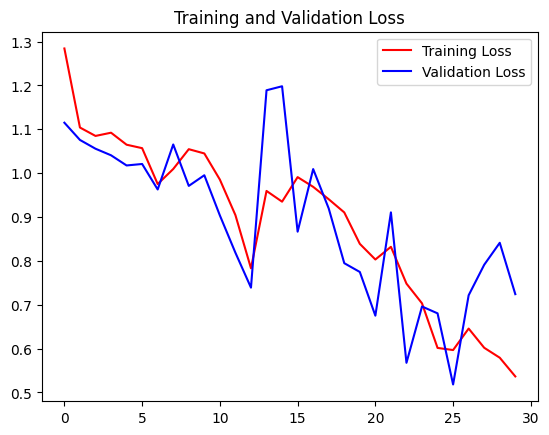

In [50]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc = 'best')
plt.show()

Saving airplane956.jpg to airplane956.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
airplane956.jpg
This image belongs to class airplane


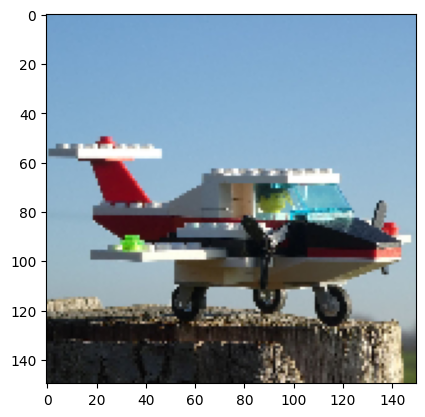

In [53]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
import os

uploaded = files.upload()

# Ambil daftar nama kelas dari training_generator
class_list = list(training_generator.class_indices.keys())

#  Proses Tiap File yang Di-upload dan Persiapkan Gambar
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

# Prediksi
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  predicted_index = np.argmax(classes[0])
  print('This image belongs to class', class_list[predicted_index])
